In [1]:
from src.data import extract_vault, holdout, delete_nodes_without_links
import matplotlib.pyplot as plt 
import networkx as nx
import numpy as np
from src.model_base import calculate_adamic_adar, create_pairs_for_nodes, generate_recomendations, evaluate_baseline
from tqdm import tqdm
from copy import deepcopy
import pandas as pd
from src.metrics import recall_n
from pathlib import Path

In [2]:
vault_path = Path('./vaultes/obsidian-hub/')
vault = extract_vault(vault_path)
vault_graph = deepcopy(vault.graph)
delete_nodes_without_links(vault_graph)

Front matter not populated for T - Thecookiemomma's Daily Log.md: ParserError('while parsing a block mapping', <yaml._yaml.Mark object at 0x7f6083f8f5e0>, 'did not find expected key', <yaml._yaml.Mark object at 0x7f6083f8fef0>)
Front matter not populated for T - Thecookiemomma's Daily Log.md: ParserError('while parsing a block mapping', <yaml._yaml.Mark object at 0x7f6083de3450>, 'did not find expected key', <yaml._yaml.Mark object at 0x7f6083de3220>)
Front matter not populated for kepano.md: ScannerError('while scanning for the next token', <yaml._yaml.Mark object at 0x7f6083912cc0>, 'found character that cannot start any token', <yaml._yaml.Mark object at 0x7f6083912ae0>)
Front matter not populated for kepano.md: ScannerError('while scanning for the next token', <yaml._yaml.Mark object at 0x7f6083345450>, 'found character that cannot start any token', <yaml._yaml.Mark object at 0x7f6083345900>)
Front matter not populated for gavinmn.md: ScannerError('while scanning for the next token

## Baseline prediction and scoring

In [3]:
train_graph, holdout_links = holdout(vault.graph, seed=42, alpha=0.1)
sum([hl in train_graph.edges for hl in holdout_links])

146

In [4]:
# for hl in holdout_links:
#     print(hl[0])

In [5]:
holdout_nodes = [hl[0] for hl in holdout_links]
pairs = create_pairs_for_nodes(nodes=holdout_nodes, graph=train_graph, tqdm_disable=False)
scores = calculate_adamic_adar(graph=train_graph, pair_nodes=pairs).groupby('node_from').agg(lambda x: list(x))

100%|██████████| 1023/1023 [01:49<00:00,  9.31it/s]


In [ ]:
recs = generate_recomendations(scores)

In [ ]:
# recs

In [ ]:
import pandas as pd
holdout_links_df = pd.DataFrame.from_records(holdout_links, columns=['note_id', 'notes_to', 'p']).groupby('note_id').agg(lambda x: list(x))[['notes_to']]

In [ ]:
# holdout_links_df

In [ ]:
from src.metrics import recall_n

In [ ]:
recall_n(recs=recs, holdout_links=holdout_links_df, topn=10)

0.3

## Evaluate on different splittings

In [34]:
alpha = 0.1
topn = 20
n_exp = 1000
recall = evaluate_baseline(graph=vault_graph, n_exp=n_exp, alpha=alpha, topn=topn)

100%|██████████| 1000/1000 [00:23<00:00, 43.21it/s]


In [35]:
np.mean(recall)

0.408878857022607

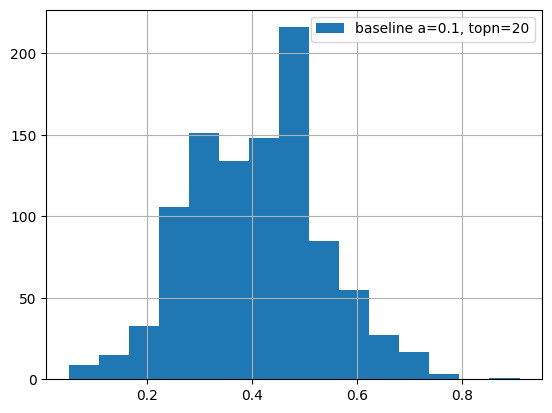

In [36]:
fig, ax = plt.subplots(1)
hist = pd.DataFrame(recall).hist(bins=15, ax=ax, label=f'baseline a={alpha}, topn={topn}')
ax.legend(loc='best')
ax.set_title('')
plt.savefig(f'./results/baseline/alpha={alpha}_topn={topn}_n_exp={n_exp}_vault={vault_path.name}.png', dpi=300)

100%|██████████| 1000/1000 [00:26<00:00, 38.07it/s]


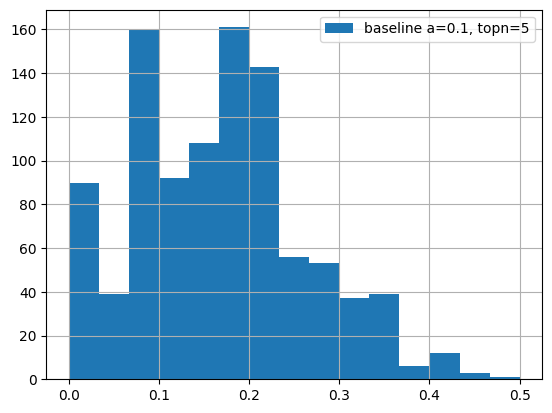

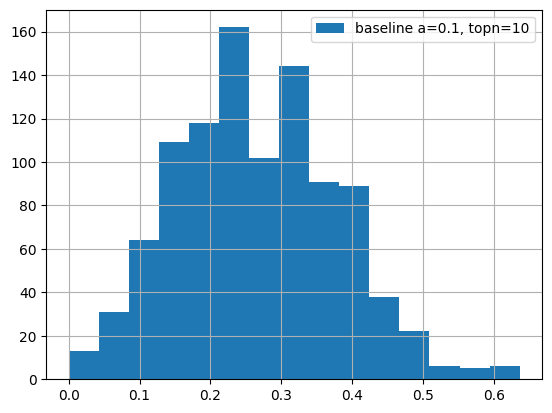

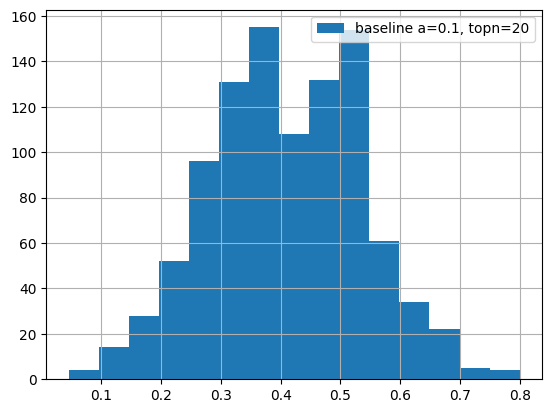

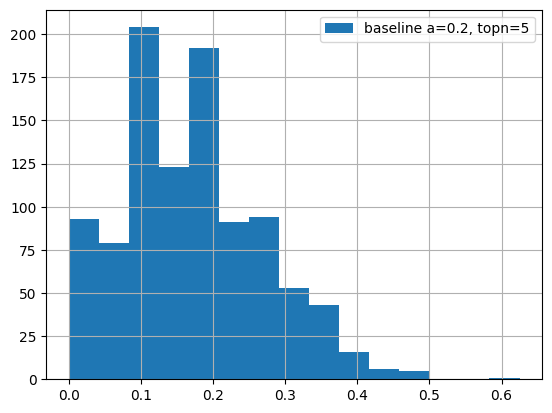

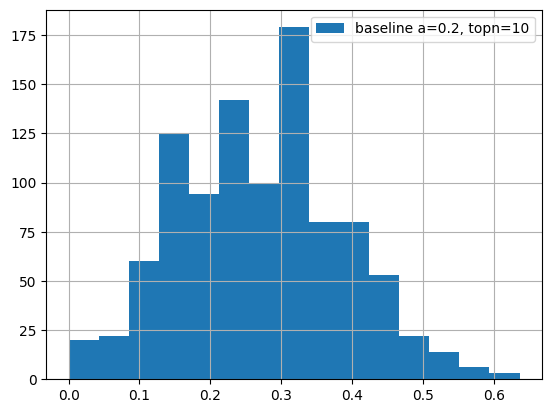

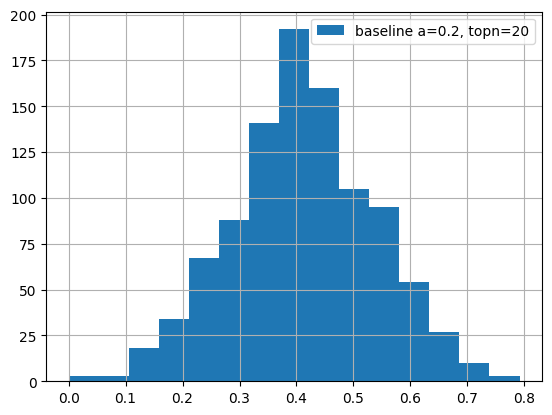

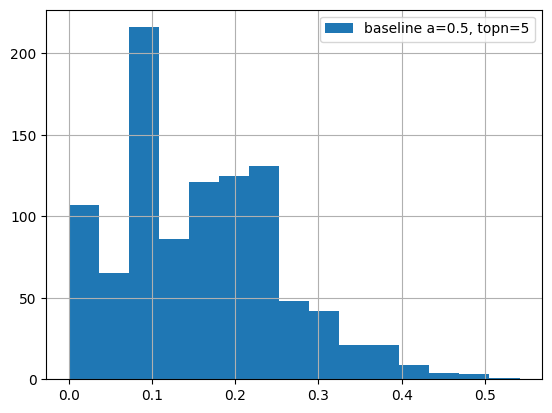

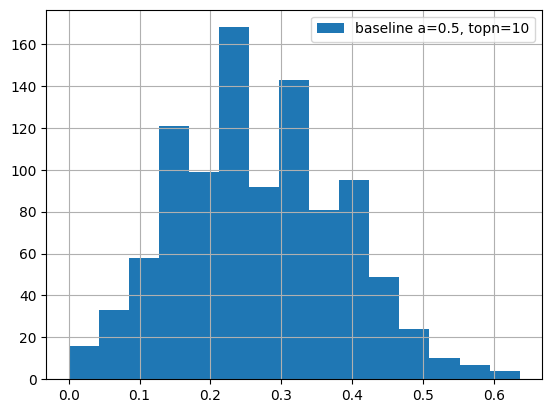

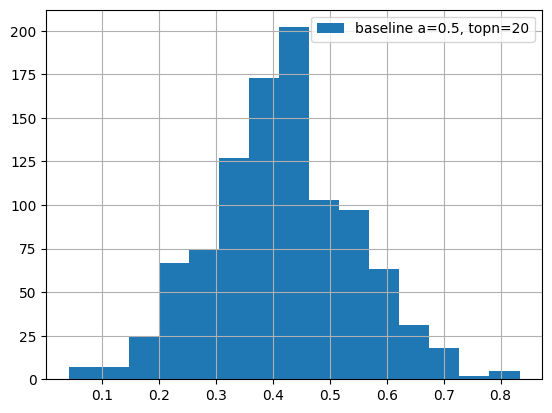

In [37]:
alphas = [0.1, 0.2, 0.5]
topns = [5, 10, 20]
data_recall = {}
for alpha in alphas:
    for topn in topns:
        recall = evaluate_baseline(graph=vault_graph, n_exp=n_exp, alpha=alpha, topn=topn)
        fig, ax = plt.subplots(1)
        hist = pd.DataFrame(recall).hist(bins=15, ax=ax, label=f'baseline a={alpha}, topn={topn}')
        ax.legend(loc='best')
        ax.set_title('')
        plt.savefig(f'./results/baseline/alpha={alpha}_topn={topn}_n_exp={n_exp}_vault={vault_path.name}.png', dpi=300)

        data_recall[(alpha, topn)] = np.mean(recall)

In [45]:
df_res = pd.DataFrame(data_recall, index=[0])
df_res.to_csv('baseline_results.csv')

In [46]:
df_res

0.1                           0.2                           0.5  \
         5         10        20        5         10        20        5    
0  0.162994  0.268819  0.407255  0.162576  0.273579  0.411508  0.155702   

                       
         10        20  
0  0.272195  0.419812

In [47]:
data_recall

{(0.1, 5): 0.16299429875679874,
 (0.1, 10): 0.26881922521922524,
 (0.1, 20): 0.40725452279202273,
 (0.2, 5): 0.16257566507566507,
 (0.2, 10): 0.27357927489177486,
 (0.2, 20): 0.41150823944573944,
 (0.5, 5): 0.1557018049080549,
 (0.5, 10): 0.27219533475783475,
 (0.5, 20): 0.419812407962408}